# Project writeup for project 7

#### Loading packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from numpy.typing import ArrayLike
from typing import List, Union

import itertools

import numpy as np
from sklearn import datasets
from nn import nn, preprocess, io
import matplotlib.pyplot as plt

# Step 2: generate your autoencoder

#### Read in toy digits dataset

In [3]:
digits = datasets.load_digits()
x = digits['data']

#### Generate a train/test split

In [4]:
def train_test_split(
    x: Union[List[Union[float, int]], ArrayLike],
    y: [Union[List[Union[float, int]], ArrayLike]],
    test_ratio: float = 0.3,
):
    """
    Generates a training and testing split with test ratio `test_ratio' for the provided x and y labels
    
    """
    
    assert len(x) == len(y), 'x and y lists are not equal length'
    
    xypairs = list(zip(x, y)) # stick x and y into a list lists

    test_sz = int(len(x) * test_ratio)
    all_indices = np.arange(len(x))

    test_indices = np.random.choice(all_indices, size=test_sz, replace=False) # randomly sample indices
    train_indices = [ind for ind in all_indices if ind not in test_indices]

    x_test, y_test, x_train, y_train = [], [], [], []

    # add random indices for train/test to appropriate lists
    for ind in test_indices:
        x_test.append(xypairs[ind][0])
        y_test.append(xypairs[ind][1])
    for ind in train_indices:
        x_train.append(xypairs[ind][0])
        y_train.append(xypairs[ind][1])

    return x_train, y_train, x_test, y_test

In [5]:
x_train, y_train, x_test, y_test = train_test_split(x, x)
data = train_test_split(x, x)

arch = [{'input_dim': 64, 'output_dim': 16}, {'input_dim': 16, 'output_dim': 64}]
seed = 0

## Hyperparameter tuning
* I chose to implement a grid search over some possible hyperparameter settings for this task
* I trained a model for each hyperparameter combination and then chose the one with the best validation loss

* We want to use mean squared error loss because for the autoencoder task we want to learn a representation that can be used to reconstruct the original data pixel intensities 

In [6]:
lr_grid = [1e-1, 1e-2, 1e-3, 1e-4]
bs_grid = [50, 100, 200, 400, 800]
epochs_grid = [5, 10, 20, 30, 40, 50, 100]

In [7]:
test_losses_grid = {}
models_grid = {}

for grid_combination in itertools.product(lr_grid, bs_grid, epochs_grid): # loop over all combinations
    lr, bs, epochs = grid_combination
    network = nn.NeuralNetwork(arch, lr, seed, bs, epochs, 'mse', activations=['sigmoid', None]) 
    # intuitively i dont think we want to 0-1 bound the predictions, although probably doesn't matter all that much
    train_losses, test_losses = network.fit(x_train, y_train, x_test, y_test)
    last_test_loss = test_losses[-1] # for recording in dict
    
    # code does this but wanted to make it clear to reader losses are stored as attr
    network.train_losses = train_losses
    network.test_losses = test_losses
    
    grid_key = (lr, bs, epochs)
    test_losses_grid[grid_key] = last_test_loss
    models_grid[grid_key] = network

In [8]:
best_grid_param = min(test_losses_grid, key=test_losses_grid.get) # get hparam key with best loss
best_loss_val = test_losses_grid[best_grid_param] # get best loss
best_network = models_grid[best_grid_param] # get best model

In [9]:
print(f'Best LR: {best_grid_param[0]}')
print(f'Best BS: {best_grid_param[1]}')
print(f'Best #Epochs: {best_grid_param[2]}')

Best LR: 0.1
Best BS: 50
Best #Epochs: 100


#### Plot training and testing loss per epoch

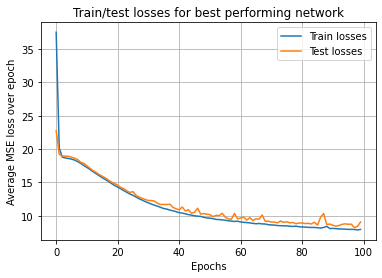

In [10]:
plt.plot(best_network.train_losses, label='Train losses')
plt.plot(best_network.test_losses, label='Test losses')
_ = plt.title('Train/test losses for best performing network')
_ = plt.grid()
_ = plt.legend()
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Average MSE loss over epoch')

#### Quantify your average reconstruction error over the dataset

In [11]:
loss_across_dataset = best_network._eval_loader(x_test, x_test, train=False)
loss_across_dataset = np.round(loss_across_dataset, 3)
print(f'Average loss across dataset: {loss_across_dataset}')

Average loss across dataset: 9.072


# Step 3: generate your transcription factor classifier

#### Read in data

In [12]:
positive_examples = io.read_text_file('data/rap1-lieb-positives.txt')
negative_examples = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')

len_positives = len(positive_examples[0])

# generate three subsequences of length same as positive examples from each negative sequence to make sure all data X's are same len
n_subseq_per_negative = 3
negative_examples_subseq = []
for example in negative_examples:
    possible_indices = np.arange(len(example) + len_positives - 1) # get all indices that can produce a sequence of appropriate length
    random_start_indices = np.random.choice(possible_indices, size=n_subseq_per_negative, replace=False) # chose n_subseq_per_negative from ^
    
    for random_start in random_start_indices:
        negative_examples_subseq.append(example[random_start: random_start+len_positives]) # add to negative_examples_subseq

#### Resample to have equal class balance

In [13]:
# stick pos and negative examples together (3 subsequences per regular negative example)
all_examples = [positive_examples + negative_examples_subseq, [0] * len(positive_examples) + [1] * len(negative_examples_subseq)] 
resampled_seqs, resampled_labels = preprocess.sample_seqs(*all_examples) # resample to equal class balance
resampled_seqs_ohe = preprocess.one_hot_encode_seqs(resampled_seqs) # OHE the sequenecs

assert len(set(len(seq) for seq in resampled_seqs_ohe)) == 1 # all same length OHE's

#### Convert labels to OHE

In [14]:
resampled_labels_ohe = np.zeros((len(resampled_labels), 2))

# convert one dim class indicator vector (n x 1) to two dim OHE (n x 2)

for idx, label in enumerate(resampled_labels):
    if label == 0:
        resampled_labels_ohe[idx, label] = 1
    else:
        resampled_labels_ohe[idx, label] = 1
        
assert len(resampled_labels) == resampled_labels_ohe.sum(1).sum() # make sure the rows (data points) only have one label

#### Generate train/test split

In [15]:
x_train, y_train, x_test, y_test = train_test_split(resampled_seqs_ohe, resampled_labels_ohe)
arch = [{'input_dim': 68, 'output_dim': 34}, {'input_dim': 34, 'output_dim': 2}] # no particular reason why hidden layer has to be 34
seed = 0

#### Train network using hyperparameter grid search

In [16]:
lr_grid = [1e-1, 1e-2]
bs_grid = [100, 400, 1600]
epochs_grid = [5, 10, 40, 80]

In [17]:
# see corresponding cell above for the autoencoder task for further explanation 

clf_test_losses_grid = {}
clf_models_grid = {}

for grid_combination in itertools.product(lr_grid, bs_grid, epochs_grid):
    lr, bs, epoch = grid_combination
    network = nn.NeuralNetwork(arch, lr, seed, bs, epochs, 'ce', activations=['sigmoid', 'sigmoid'])
    train_losses, test_losses = network.fit(x_train, y_train, x_test, y_test)
    last_test_loss = test_losses[-1]
    
    # code does this but wanted to make it clear to reader losses are stored as attr
    network.train_losses = train_losses
    network.test_losses = test_losses
    
    grid_key = (lr, bs, epoch)
    clf_test_losses_grid[grid_key] = last_test_loss
    clf_models_grid[grid_key] = network

In [18]:
best_grid_param_clf = min(clf_test_losses_grid, key=clf_test_losses_grid.get) # get hparams key with lowest loss
best_loss_val_clf = clf_test_losses_grid[best_grid_param_clf] # get best loss
best_network_clf = clf_models_grid[best_grid_param_clf] # get best models

#### Choice of loss function:
* I chose to use **cross entropy loss** because we want this neural network to output probabilities over the two classes during prediction

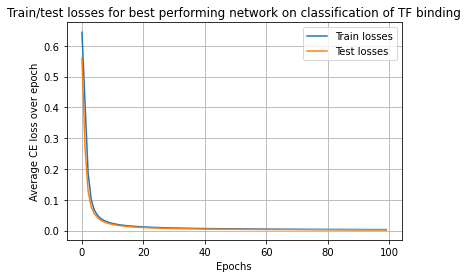

In [19]:
plt.plot(best_network_clf.train_losses, label='Train losses')
plt.plot(best_network_clf.test_losses, label='Test losses')
_ = plt.title('Train/test losses for best performing network on classification of TF binding')
_ = plt.grid()
_ = plt.legend()
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Average CE loss over epoch')

#### Print out accuracy on test set

In [20]:
preds = network.predict(np.array(x_test)).argmax(1) # one dim vector of class pred 0's and 1's
y_test_gt = np.array(y_test).argmax(1)

accuracy = np.isclose(preds, y_test_gt).sum() / len(preds)
print(f'Accuracy for test set: {accuracy.round(3)}')

Accuracy for test set: 0.984
